In [1]:
import numpy as np

from scipy.optimize import minimize
import matplotlib.pyplot as plt
import math
from scipy.optimize import minimize_scalar

In [2]:
from scipy.optimize import Bounds

bounds = Bounds([0, -0.5], [1.0, 2.0])

In [3]:
from scipy.optimize import LinearConstraint

linear_constraint = LinearConstraint([[1, 2], [2, 1]], [-np.inf, 1], [1, 1])


In [4]:
## DEFINE FUNCTIONS FOR FITNESS, CONDITION AND INVESTMENT CAPABILITY



def sigmoid(x):
    return 1 / (0.8 + math.exp(-x))

def logifunc(x,kf,af,bf):
    return kf/(1+af*math.exp(-bf*x))


def male_fitness(x):
    km=1
    am=80
    bm=10


    """The Rosenbrock function"""

    return km/(1+am*math.exp(-bm*x))

def female_fitness(x):
    bf=4.5324681549033698521644401984791
    kf=4/5
    af =3

    """The Rosenbrock function"""

    return kf/(1+af*math.exp(-bf*x))



    
# CONVEX FITNESS
#def male_fitness(x):

 #   return x**2

#def female_fitness(x):
 #   kx=0.2
  #  lx=0.266
   # return kx+lx*x



def offs_condition(c_m,i):

    """The Rosenbrock function"""

    return 0.5*c_m + 0.5*i**0.5

def investment(c_m):
    d1=1
    d2=1
    d3=20

    return d1/(1+d2 *math.exp(-d3*(c_m - 0.5)))



def all_males(i,c_m,sign=-1):
    return sign*(male_fitness(offs_condition(c_m,i)) + male_fitness(offs_condition(c_m,investment(c_m)-i)))

def mixed(i,c_m,sign=-1):
    return sign*(male_fitness(offs_condition(c_m,i)) + female_fitness(offs_condition(c_m,investment(c_m)-i)))

def all_females(i,c_m,sign=-1):
    return sign*(female_fitness(offs_condition(c_m,i)) + female_fitness(offs_condition(c_m,investment(c_m)-i)))

                                                        


def find_sexratio(x, i_star_ma, i_star_fe, i_star_mi,c_m,sign=-1):
    return (x*x * all_males(i_star_ma,c_m) + (1-x)*(1-x) * all_females(i_star_fe,c_m) + (2* x *(1-x) )*mixed(i_star_mi,c_m)  )                                          
     

In [5]:
## OPTIMIZATION FUNCTIONS 

def optimal_Basic(c_m,x_0_inv,x_0_sr):

    i_star_ma = minimize_scalar(all_males, x_0_inv,bounds=(0,investment(c_m)),method='bounded',args=(c_m))
    i_star_fe = minimize_scalar(all_females, x_0_inv,bounds=(0,investment(c_m)),method='bounded',args=(c_m))
    i_star_mi = minimize_scalar(mixed, x_0_inv,bounds=(0,investment(c_m)),method='bounded',args=(c_m))
    
    alpha_star = minimize_scalar(find_sexratio, x_0_sr,bounds=(0,1),method='bounded',args=(i_star_ma.x, i_star_fe.x, i_star_mi.x,c_m))

    return i_star_ma.x, i_star_fe.x, i_star_mi.x, alpha_star.x


def mixed_Unc(i,c_m,phi,sign=-1):
    ca_1 =  min(np.abs(phi + offs_condition(c_m,i)),1 )
    ca_2 =  min(np.abs(phi + offs_condition(c_m,investment(c_m)-i)),1 )
    
    return sign*(male_fitness(ca_1) + female_fitness(ca_2))

def all_males_Unc(i,c_m,phi,sign=-1):
    ca_1 =  min(np.abs(phi + offs_condition(c_m,i)),1 )
    ca_2 =  min(np.abs(phi + offs_condition(c_m,investment(c_m)-i)),1 )
    return sign*(male_fitness(ca_1) + male_fitness(ca_2))

def all_females_Unc(i,c_m,phi,sign=-1):
    ca_1 =  min(np.abs(phi + offs_condition(c_m,i)),1 )
    ca_2 =  min(np.abs(phi + offs_condition(c_m,investment(c_m)-i)),1 )
    return sign*(female_fitness(ca_1) + female_fitness(ca_2))



def find_sexratio_Unc(x, i_star_ma_b, i_star_fe_b, i_star_mi_b,i_star_ma_n, i_star_fe_n, i_star_mi_n,i_star_ma_w, i_star_fe_w, i_star_mi_w,c_m,P,phi,sign=-1):
    
    b=P[ct][0]*(x*x * all_males_Unc(i_star_ma_b,c_m,phi) + (1-x)*(1-x) * all_females_Unc(i_star_fe_b,c_m,phi) + (2* x *(1-x) )*mixed_Unc(i_star_mi_b,c_m,phi)  )                                          
    n=P[ct][1]*(x*x * all_males_Unc(i_star_ma_n,c_m,0) + (1-x)*(1-x) * all_females_Unc(i_star_fe_n,c_m,0) + (2* x *(1-x) )*mixed_Unc(i_star_mi_n,c_m,0)  )                                          
    w=P[ct][2]*(x*x * all_males_Unc(i_star_ma_w,c_m,-phi) + (1-x)*(1-x) * all_females_Unc(i_star_fe_w,c_m,-phi) + (2* x *(1-x) )*mixed_Unc(i_star_mi_w,c_m,-phi)  )                                            
    
    return b+n+w


def optimal_Unc(c_m,P,ct,phi,x_0_inv,x_0_sr):   
    
    i_star_mi_b = minimize_scalar(mixed_Unc, x_0_inv,bounds=(0,investment(c_m)),method='bounded',args=(c_m,phi))
    
    i_star_mi_n = minimize_scalar(mixed_Unc, x_0_inv,bounds=(0,investment(c_m)),method='bounded',args=(c_m,0))
    
    i_star_mi_w = minimize_scalar(mixed_Unc, x_0_inv,bounds=(0,investment(c_m)),method='bounded',args=(c_m,-phi))
    
    
    i_star_ma_b = minimize_scalar(all_males_Unc, x_0_inv,bounds=(0,investment(c_m)),method='bounded',args=(c_m,phi))
    
    i_star_ma_n = minimize_scalar(all_males_Unc, x_0_inv,bounds=(0,investment(c_m)),method='bounded',args=(c_m,0))
    
    i_star_ma_w = minimize_scalar(all_males_Unc, x_0_inv,bounds=(0,investment(c_m)),method='bounded',args=(c_m,-phi))
 
   
    i_star_fe_b = minimize_scalar(all_males_Unc, x_0_inv,bounds=(0,investment(c_m)),method='bounded',args=(c_m,phi))
    
    i_star_fe_n = minimize_scalar(all_females_Unc, x_0_inv,bounds=(0,investment(c_m)),method='bounded',args=(c_m,0))
    
    i_star_fe_w = minimize_scalar(all_females_Unc, x_0_inv,bounds=(0,investment(c_m)),method='bounded',args=(c_m,-phi))
   
   
    alpha_star = minimize_scalar(find_sexratio_Unc, x_0_sr,bounds=(0,1),method='bounded',args=(i_star_ma_b.x, i_star_fe_b.x, i_star_mi_b.x,i_star_ma_n.x, i_star_fe_n.x, i_star_mi_n.x,i_star_ma_w.x, i_star_fe_w.x, i_star_mi_w.x,c_m,P,phi))
    
    
    i_star_fe=P[ct][0]*i_star_fe_b.x + P[ct][1]*i_star_fe_n.x + P[ct][2]*i_star_fe_w.x 
    
    i_star_ma=P[ct][0]*i_star_ma_b.x + P[ct][1]*i_star_ma_n.x + P[ct][2]*i_star_ma_w.x 
    
    i_star_mi=P[ct][0]*i_star_mi_b.x + P[ct][1]*i_star_mi_n.x + P[ct][2]*i_star_mi_w.x 

    return i_star_ma, i_star_fe, i_star_mi, alpha_star.x, -alpha_star.fun





In [6]:
## OPTIMIZATION FUNCTIONS 
# CONVEX FITNESS
#def male_fitness(x):

 #   return x**2

#def female_fitness(x):
  #  kx=0.2
 #   lx=0.266
#    return kx+lx*x

def optimal_Basic(c_m,x_0_inv,x_0_sr):

    i_star_ma = minimize_scalar(all_males, x_0_inv,bounds=(0,investment(c_m)),method='bounded',args=(c_m))
    i_star_fe = minimize_scalar(all_females, x_0_inv,bounds=(0,investment(c_m)),method='bounded',args=(c_m))
    i_star_mi = minimize_scalar(mixed, x_0_inv,bounds=(0,investment(c_m)),method='bounded',args=(c_m))
    
    alpha_star = minimize_scalar(find_sexratio, x_0_sr,bounds=(0,1),method='bounded',args=(i_star_ma.x, i_star_fe.x, i_star_mi.x,c_m))

    return i_star_ma.x, i_star_fe.x, i_star_mi.x, alpha_star.x


def mixed_Unc(i,c_m,phi,sign=-1):
    return sign*(male_fitness(offs_condition(c_m,i)+phi) + female_fitness(offs_condition(c_m,investment(c_m)-i)+phi))

def all_males_Unc(i,c_m,phi,sign=-1):
    return sign*(male_fitness(offs_condition(c_m,i)+phi) + male_fitness(offs_condition(c_m,investment(c_m)-i)+phi))

def all_females_Unc(i,c_m,phi,sign=-1):
    return sign*(female_fitness(offs_condition(c_m,i)+phi) + female_fitness(offs_condition(c_m,investment(c_m)-i)+phi))




def find_sexratio_Unc(x, i_star_ma_b, i_star_fe_b, i_star_mi_b,i_star_ma_n, i_star_fe_n, i_star_mi_n,i_star_ma_w, i_star_fe_w, i_star_mi_w,c_m,P,phi,sign=-1):
    
    b=P[ct][0]*(x*x * all_males_Unc(i_star_ma_b,c_m,phi) + (1-x)*(1-x) * all_females_Unc(i_star_fe_b,c_m,phi) + (2* x *(1-x) )*mixed_Unc(i_star_mi_b,c_m,phi)  )                                          
    n=P[ct][1]*(x*x * all_males_Unc(i_star_ma_n,c_m,0) + (1-x)*(1-x) * all_females_Unc(i_star_fe_n,c_m,0) + (2* x *(1-x) )*mixed_Unc(i_star_mi_n,c_m,0)  )                                          
    w=P[ct][2]*(x*x * all_males_Unc(i_star_ma_w,c_m,-phi) + (1-x)*(1-x) * all_females_Unc(i_star_fe_w,c_m,-phi) + (2* x *(1-x) )*mixed_Unc(i_star_mi_w,c_m,-phi)  )                                            
    
    return b+n+w


def optimal_Unc(c_m,P,ct,phi,x_0_inv,x_0_sr):   
    
    i_star_mi_b = minimize_scalar(mixed_Unc, x_0_inv,bounds=(0,investment(c_m)),method='bounded',args=(c_m,phi))
    
    i_star_mi_n = minimize_scalar(mixed_Unc, x_0_inv,bounds=(0,investment(c_m)),method='bounded',args=(c_m,0))
    
    i_star_mi_w = minimize_scalar(mixed_Unc, x_0_inv,bounds=(0,investment(c_m)),method='bounded',args=(c_m,-phi))
    
    
    i_star_ma_b = minimize_scalar(all_males_Unc, x_0_inv,bounds=(0,investment(c_m)),method='bounded',args=(c_m,phi))
    
    i_star_ma_n = minimize_scalar(all_males_Unc, x_0_inv,bounds=(0,investment(c_m)),method='bounded',args=(c_m,0))
    
    i_star_ma_w = minimize_scalar(all_males_Unc, x_0_inv,bounds=(0,investment(c_m)),method='bounded',args=(c_m,-phi))
 
   
    i_star_fe_b = minimize_scalar(all_males_Unc, x_0_inv,bounds=(0,investment(c_m)),method='bounded',args=(c_m,phi))
    
    i_star_fe_n = minimize_scalar(all_females_Unc, x_0_inv,bounds=(0,investment(c_m)),method='bounded',args=(c_m,0))
    
    i_star_fe_w = minimize_scalar(all_females_Unc, x_0_inv,bounds=(0,investment(c_m)),method='bounded',args=(c_m,-phi))
   
   
    alpha_star = minimize_scalar(find_sexratio_Unc, x_0_sr,bounds=(0,1),method='bounded',args=(i_star_ma_b.x, i_star_fe_b.x, i_star_mi_b.x,i_star_ma_n.x, i_star_fe_n.x, i_star_mi_n.x,i_star_ma_w.x, i_star_fe_w.x, i_star_mi_w.x,c_m,P,phi))
    
    
    i_star_fe=P[ct][0]*i_star_fe_b.x + P[ct][1]*i_star_fe_n.x + P[ct][2]*i_star_fe_w.x 
    
    i_star_ma=P[ct][0]*i_star_ma_b.x + P[ct][1]*i_star_ma_n.x + P[ct][2]*i_star_ma_w.x 
    
    i_star_mi=P[ct][0]*i_star_mi_b.x + P[ct][1]*i_star_mi_n.x + P[ct][2]*i_star_mi_w.x 

    return i_star_ma, i_star_fe, i_star_mi, alpha_star.x, -alpha_star.fun





In [7]:

def fr(x,i_star_ma, i_star_fe, i_star_mi,cm,epsilon):
    
    return (x*x * all_males_Unc(i_star_ma,c_m,epsilon) + (1-x)*(1-x) * all_females_Unc(i_star_fe,c_m,epsilon) + (2* x *(1-x) )*mixed_Unc(i_star_mi,c_m,epsilon)  )                                          
     

def realized_fitness(x,i_star_ma, i_star_fe, i_star_mi,cm,nt,phi,kappa):
    
    x=np.round(2*x)/2
    if nt==0:
        epsilon=np.random.normal(phi,kappa)
        FR=fr(x,i_star_ma, i_star_fe, i_star_mi,cm,epsilon)
    
    if nt==1:
        epsilon=np.random.normal(0,kappa)
        FR=fr(x,i_star_ma, i_star_fe, i_star_mi,cm,epsilon)
    
    if nt==2:
        epsilon=np.random.normal(-phi,kappa)
        FR=fr(x,i_star_ma, i_star_fe, i_star_mi,cm,epsilon)
    
    return -FR
        
def random_fitness(cm,nt,phi,kappa):
    
    x=np.round(2*np.random.random())/2
    i2=investment(cm)
    if nt==0:
        epsilon=np.random.normal(phi,kappa)
        FR=fr(x,i2,i2,i2,cm,epsilon)
    
    if nt==1:
        epsilon=np.random.normal(0,kappa)        
        FR=fr(x,i2,i2,i2,cm,epsilon)
    
    if nt==2:
        epsilon=np.random.normal(-phi,kappa)
        FR=fr(x,i2,i2,i2,cm,epsilon)
    
    return -FR        

In [9]:
c_m=0.9

#bounds_inv = Bounds([0, investment(c_m)])
x_0_inv=0.5
x_0_sr = 0

print(optimal_Basic(c_m,x_0_inv,x_0_sr))
P=[(0.4,0.3,0.1),(0.2,0.6,0.2),(0.1,0.3,0.4)]
ct=1

phi=0.2
nt=2
phi=0.2
kappa=0.10


i_star_ma=optimal_Unc(c_m,P,ct,phi,x_0_inv,x_0_sr)[0]
i_star_fe=optimal_Unc(c_m,P,ct,phi,x_0_inv,x_0_sr)[1]
i_star_mi=optimal_Unc(c_m,P,ct,phi,x_0_inv,x_0_sr)[2]
x=optimal_Unc(c_m,P,ct,phi,x_0_inv,x_0_sr)[3]
fval=optimal_Unc(c_m,P,ct,phi,x_0_inv,x_0_sr)[-1]

FR=realized_fitness(x,i_star_ma, i_star_fe, i_star_mi,c_m,nt,phi,kappa)
F0=random_fitness(c_m,nt,phi,kappa)
print('Expected fitness',fval)
print('Realized fitness',FR)
print('Random fitness',F0)

(0.4998323249347658, 0.4998323249347667, 0.5005659592157281, 0.9999940391390134)
Expected fitness 1.9040002672395304
Realized fitness 1.5697083992677698
Random fitness 1.0061598219960617


In [8]:

class MarkovChain(object):
    def __init__(self, transition_matrix,states):

        self.transition_matrix=np.atleast_2d(transition_matrix)
        self.states=states
        self.index_dict={self.states[index]:index for index in range(len(self.states))}
        self.state_dict={index: self.states[index] for index in range(len(self.states))}
        
    def next_state(self, current_state):
        
        return np.random.choice(self.states,p=self.transition_matrix[self.index_dict[current_state],:])
    
    def generate_states(self, current_state, no=10):
        future_states=[]
        for i in range(no):
            next_state=self.next_state(current_state)
            future_states.append(next_state)
            current_state=next_state
        return future_states
    


In [11]:
## GET MARKOV THINGS READY

P=[(0.5,0.4,0.1),(0.1,0.8,0.1),(0.1,0.4,0.5)]
transition_matrix=np.asarray(P)
transition_matrix
states_chain=MarkovChain(transition_matrix=transition_matrix, states=[0,1,2])
states_chain.next_state(current_state=1)
states_chain.generate_states(current_state=0,no=10)


#We have to transpose so that Markov transitions correspond to right multiplying by a column vector.  np.linalg.eig finds right eigenvectors.
Q=np.asarray(P)
evals, evecs = np.linalg.eig(Q.T)
evec1 = evecs[:,np.isclose(evals, 1)]

#Since np.isclose will return an array, we've indexed with an array
#so we still have our 2nd axis.  Get rid of it, since it's only size 1.
evec1 = evec1[:,0]

stationary = evec1 / evec1.sum()

#eigs finds complex eigenvalues and eigenvectors, so you'll want the real part.
stationary = stationary.real
print(stationary)

[0.16666667 0.66666667 0.16666667]


In [38]:
import numpy as np
import pandas as pd
from random import seed
from random import random
import matplotlib.pyplot as plt

N=5000 #number of conditions
mu=0.5
sigma=0.1
cms=np.random.normal(mu,sigma,N)

# different fitness figure
kappa=0.5
phi=0.3
p=0.1

P=[(0.6,0.3,0.1),(3*p/4,1-p,p/4),(0.1,0.4,0.5)]

transition_matrix=np.asarray(P)
transition_matrix
states_chain=MarkovChain(transition_matrix=transition_matrix, states=[0,1,2])
states_chain.next_state(current_state=1)
states_chain.generate_states(current_state=0,no=10)

pi=stationary

# if current is 0
ct=0
f_vals_cb=[]
FRs_cb=[]
F0_cb=[]
x_b=[]

inv_b=[]

for i in np.arange(len(cms)):
    c_m=cms[i] 
    results=optimal_Unc(c_m,P,ct,phi,x_0_inv,x_0_sr)
    i_star_ma=results[0]
    i_star_fe=results[1]
    i_star_mi=results[2]
    x=results[3]
    inv_b.append(i_star_mi/investment(c_m))
    x_b.append(x)
    f_vals_cb.append(results[4])
    nt=states_chain.next_state(current_state=ct)
    
    FRs_cb.append(realized_fitness(x,i_star_ma, i_star_fe, i_star_mi,c_m,nt,phi,kappa))
    
    F0_cb.append(random_fitness(c_m,nt,phi,kappa))

ct=1
f_vals_cn=[]
FRs_cn=[]
F0_cn=[]
x_n=[]
inv_n=[]
for i in np.arange(len(cms)):
    c_m=cms[i] 
    results=optimal_Unc(c_m,P,ct,phi,x_0_inv,x_0_sr)
    i_star_ma=results[0]
    i_star_fe=results[1]
    i_star_mi=results[2]
    inv_n.append(i_star_mi/investment(c_m))
    x=results[3]
    x_n.append(x)
    f_vals_cn.append(results[4])
    nt=states_chain.next_state(current_state=ct)
    
    FRs_cn.append(realized_fitness(x,i_star_ma, i_star_fe, i_star_mi,c_m,nt,phi,kappa))
    
    F0_cn.append(random_fitness(c_m,nt,phi,kappa))

    
ct=2
f_vals_cw=[]
FRs_cw=[]
F0_cw=[]
x_w=[]
inv_w=[]
for i in np.arange(len(cms)):
    c_m=cms[i] 
    results=optimal_Unc(c_m,P,ct,phi,x_0_inv,x_0_sr)
    i_star_ma=results[0]
    i_star_fe=results[1]
    i_star_mi=results[2]
    inv_w.append(i_star_mi/investment(c_m))
    x=results[3]
    x_w.append(x)
    f_vals_cw.append(results[4])
    nt=states_chain.next_state(current_state=ct)
    
    FRs_cw.append(realized_fitness(x,i_star_ma, i_star_fe, i_star_mi,c_m,nt,phi,kappa))
    
    F0_cw.append(random_fitness(c_m,nt,phi,kappa))

    
Difference=pi[0]*(np.asarray(FRs_cb)-np.asarray(F0_cb))+pi[1]*(np.asarray(FRs_cn)-np.asarray(F0_cn))+pi[2]*(np.asarray(FRs_cw)-np.asarray(F0_cw))

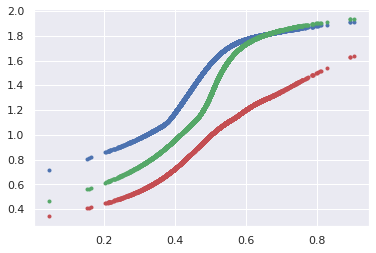

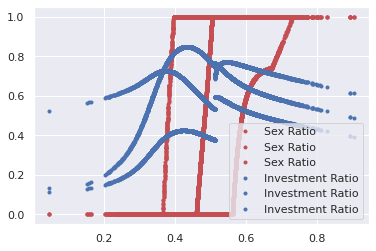

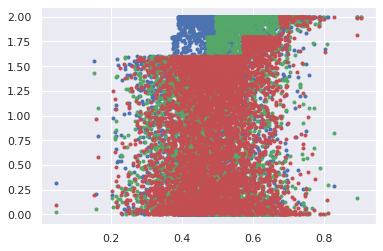

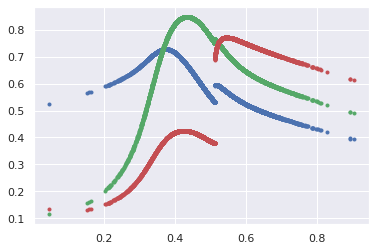

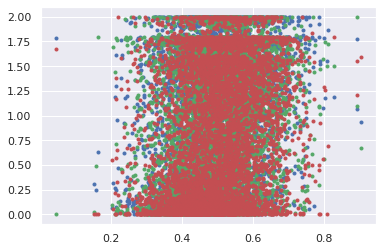

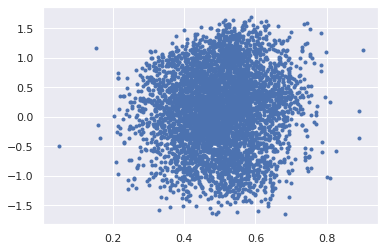

[0.16666667 0.66666667 0.16666667]


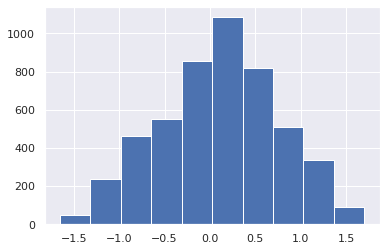

In [43]:

import matplotlib.pyplot as plt
plt.plot(cms,f_vals_cb,'b.',cms,f_vals_cn,'g.',cms,f_vals_cw,'r.')
plt.show()
plt.plot(cms,x_b,'r.',cms,x_n,'r.',cms,x_w,'r.',label='Sex Ratio')
plt.plot(cms,inv_b,'b.',cms,inv_n,'b.',cms,inv_w,'b.',label='Investment Ratio')
plt.legend()
plt.show()
plt.plot(cms,FRs_cb,'b.',cms,FRs_cn,'g.',cms,FRs_cw,'r.')
plt.show()
plt.plot(cms,inv_b,'b.',cms,inv_n,'g.',cms,inv_w,'r.')
plt.show()

plt.plot(cms,F0_cb,'b.',cms,F0_cn,'g.',cms,F0_cw,'r.')
plt.show()

plt.plot(cms,Difference,'.')
plt.show()
#print(cms,np.mean(Differenc
plt.hist(Difference)
print(pi)


In [81]:

#bounds_inv = Bounds([0, investment(c_m)])
x_0_inv=0.5
x_0_sr = 0

print(optimal_Basic(c_m,x_0_inv,x_0_sr))
P=[(0.4,0.3,0.1),(p/2,1-p,p/2),(0.1,0.3,0.4)]
ct=1

phi=0.2
nt=2
phi=0.2
kappa=0.10


i_star_ma=optimal_Unc(c_m,P,ct,phi,x_0_inv,x_0_sr)[0]
i_star_fe=optimal_Unc(c_m,P,ct,phi,x_0_inv,x_0_sr)[1]
i_star_mi=optimal_Unc(c_m,P,ct,phi,x_0_inv,x_0_sr)[2]
x=optimal_Unc(c_m,P,ct,phi,x_0_inv,x_0_sr)[3]
fval=optimal_Unc(c_m,P,ct,phi,x_0_inv,x_0_sr)[-1]

FR=realized_fitness(x,i_star_ma, i_star_fe, i_star_mi,c_m,nt,phi,kappa)

F0=random_fitness(c_m,nt,phi,kappa)
print('Expected fitness',fval)
print('Realized fitness',FR)
print('Random fitness',F0)



K=10
ps=np.linspace(0,1,K)
ks=np.linspace(0,0.5,K)
pihs=np.linspace*0,0.5,K)
## GET MARKOV THINGS READY




P=[(0.4,0.3,0.1),(p/2,1-p,p/2),(0.1,0.3,0.4)]
transition_matrix=np.asarray(P)
transition_matrix
states_chain=MarkovChain(transition_matrix=transition_matrix, states=[0,1,2])
states_chain.next_state(current_state=1)
states_chain.generate_states(current_state=0,no=10)


#We have to transpose so that Markov transitions correspond to right multiplying by a column vector.  np.linalg.eig finds right eigenvectors.
Q=np.asarray(P)
evals, evecs = np.linalg.eig(Q.T)
evec1 = evecs[:,np.isclose(evals, 1)]

#Since np.isclose will return an array, we've indexed with an array
#so we still have our 2nd axis.  Get rid of it, since it's only size 1.
evec1 = evec1[:,0]

stationary = evec1 / evec1.sum()

#eigs finds complex eigenvalues and eigenvectors, so you'll want the real part.
stationary = stationary.real
print(stationary)


SyntaxError: unmatched ')' (<ipython-input-81-b9677a092807>, line 33)

(array([  2.,  19.,  49.,  89., 128., 113.,  67.,  23.,   7.,   3.]),
 array([-0.02459632,  0.08220616,  0.18900864,  0.29581111,  0.40261359,
         0.50941607,  0.61621855,  0.72302102,  0.8298235 ,  0.93662598,
         1.04342846]),
 <BarContainer object of 10 artists>)

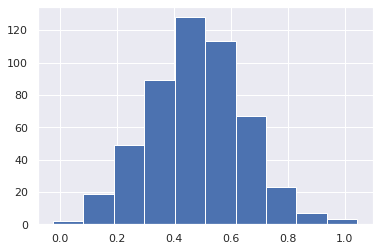

In [68]:
N=500 #number of conditions
mu=0.5
sigma=0.17
cms=np.random.normal(mu,sigma,N)
plt.hist(cms)

In [26]:


N=50 #number of conditions
mu=0.5
sigma=0.17
cms=np.random.normal(mu,sigma,N)


# different fitness figure
K=10
K2=8
K3=5


kappas=np.linspace(0,0.6,K)
phis=np.linspace(0,0.5,K2)
ps=np.linspace(0,1,K3)

Delta=np.zeros((K3,K,K2))
cmss=[]
srs=[]
invs=[]
fitness=[]
r_fitness=[]

for l in np.arange(K3):
    p=ps[l]

    P=[(0.4,0.4,0.2),(p/2,1-p,p/2),(0.2,0.4,0.4)]
    transition_matrix=np.asarray(P)
    transition_matrix
    states_chain=MarkovChain(transition_matrix=transition_matrix, states=[0,1,2])
    states_chain.next_state(current_state=1)
    states_chain.generate_states(current_state=0,no=10)

    pi=stationary


    for k in np.arange(K):
        kappa=kappas[k]
        for j in np.arange(K2):
            phi=phis[j]

            ct=0
            f_vals_cb=[]
            FRs_cb=[]
            F0_cb=[]
            x_b=[]



            for i in np.arange(len(cms)):
                c_m=cms[i] 
                results=optimal_Unc(c_m,P,ct,phi,x_0_inv,x_0_sr)
                i_star_ma=results[0]
                i_star_fe=results[1]
                i_star_mi=results[2]
                x=results[3]
                x_b.append(x)
                f_vals_cb.append(results[4])
                
                nt=states_chain.next_state(current_state=ct)
                
                F=realized_fitness(x,i_star_ma, i_star_fe, i_star_mi,c_m,nt,phi,kappa)
                
                F0=random_fitness(c_m,nt,phi,kappa)

                FRs_cb.append(realized_fitness(x,i_star_ma, i_star_fe, i_star_mi,c_m,nt,phi,kappa))

                F0_cb.append(F0)
 
                cmss.append(c_m)
                srs.append(x)
                invs.append(i_star_mi/investment(c_m))
                fitness.append(F)
                r_fitness.append(F0)
                

            ct=1
            f_vals_cn=[]
            FRs_cn=[]
            F0_cn=[]
            x_n=[]

            for i in np.arange(len(cms)):
                c_m=cms[i] 
                results=optimal_Unc(c_m,P,ct,phi,x_0_inv,x_0_sr)
                i_star_ma=results[0]
                i_star_fe=results[1]
                i_star_mi=results[2]
                x=results[3]
                x_n.append(x)
                f_vals_cn.append(results[4])
                nt=states_chain.next_state(current_state=ct)
                
                F=realized_fitness(x,i_star_ma, i_star_fe, i_star_mi,c_m,nt,phi,kappa)
                
                F0=random_fitness(c_m,nt,phi,kappa)

                FRs_cn.append(realized_fitness(x,i_star_ma, i_star_fe, i_star_mi,c_m,nt,phi,kappa))

                F0_cn.append(F0)
                
                cmss.append(c_m)
                srs.append(x)
                invs.append(i_star_mi/investment(c_m))
                fitness.append(F)
                r_fitness.append(F0)
                
                
            ct=2
            f_vals_cw=[]
            FRs_cw=[]
            F0_cw=[]
            x_w=[]
            for i in np.arange(len(cms)):
                c_m=cms[i] 
                results=optimal_Unc(c_m,P,ct,phi,x_0_inv,x_0_sr)
                i_star_ma=results[0]
                i_star_fe=results[1]
                i_star_mi=results[2]
                x=results[3]
                x_w.append(x)
                f_vals_cw.append(results[4])
                nt=states_chain.next_state(current_state=ct)                
                
                F=realized_fitness(x,i_star_ma, i_star_fe, i_star_mi,c_m,nt,phi,kappa)
                F0=random_fitness(c_m,nt,phi,kappa)

                FRs_cw.append(F)

                F0_cw.append(F0)
                
                cmss.append(c_m)
                srs.append(x)
                invs.append(i_star_mi/investment(c_m))
                fitness.append(F)
                r_fitness.append(F0)

            
            Difference=pi[0]*(np.asarray(FRs_cb)-np.asarray(F0_cb))+pi[1]*(np.asarray(FRs_cn)-np.asarray(F0_cn))+pi[2]*(np.asarray(FRs_cw)-np.asarray(F0_cw))

            print(np.mean(Difference))
            Delta[l,k,j]=np.mean(Difference)
            # if current is 0


0.38164241164588375
0.36097172162787544
0.3657443072707391
0.3482970984451649
0.3178266224055681
0.33113549444618534
0.2981286420870133
0.29936066443941434
0.28515442573662275
0.3473443687104586
0.3288327829623024
0.3253441757659594
0.2983388256024927
0.3093248749391145
0.2962846626578788
0.2494756586133633
0.385364696909575
0.24474497216472643
0.2986270971250582
0.2677131978413707
0.2138507422561127
0.2249562096369384
0.26806287542267926
0.20457537401318343
0.30519046735809197
0.29219448059973296
0.20603842789900104
0.25297620852393465
0.21611132405866665
0.1766200804985455
0.15019861714184427
0.2930761630555867
0.15310024681165824
0.25908576431660346
0.174130645607992
0.24420199244243487
0.2681560744611034
0.23358156110722497
0.1853245768271879
0.09711318423200446
0.07474369695919834
0.26166886989435384
0.05826297237042878
0.1777665919598156
0.23013865180159748
0.2267888718995736
0.17787383628727707
0.10180275313491395
0.11198470660566885
0.25983417410443865
0.07111817766665768
0.114

In [27]:
FRs_cb

[0.5361309194733861,
 1.1448623154037687,
 1.9858846218816362,
 1.7156906837225507,
 0.059895559924027994,
 0.5168148925567289,
 1.9255126211413853,
 0.0454566254192923,
 0.010944121038625357,
 1.999974540617854,
 1.9999840761113998,
 1.8641735186930979,
 1.8007681373466187,
 1.9999558696462634,
 1.9611868086131696,
 0.005762260261120955,
 1.4345611673198349,
 0.8609741034366554,
 0.7257342207656178,
 1.592378781142161,
 0.22031690236777027,
 1.2974988551560002e-05,
 1.9999999998404505,
 1.3349050901173607,
 1.6954376346929467,
 1.5728734338995427,
 0.00011941649807520377,
 1.9999352597236892,
 1.996174848819713,
 0.01168365228299131,
 0.0035015665063570156,
 1.999947614423537,
 0.029370110829562396,
 1.5959241472327734,
 1.7939678064273878,
 1.360743073512137,
 1.9989947678869449,
 1.999997957082722,
 0.6217075148975346,
 1.7706287046955422,
 1.5537534777584745,
 0.5266861078395696,
 1.5278905712220463,
 1.9975756935311701,
 0.4190900467323385,
 1.214842994721192,
 1.3477092228544716,

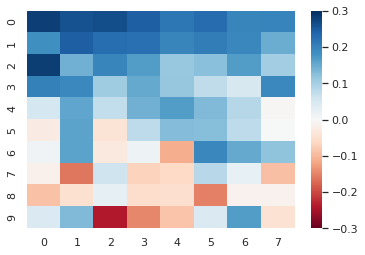

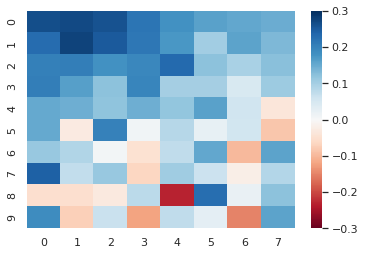

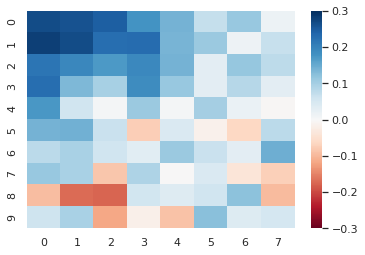

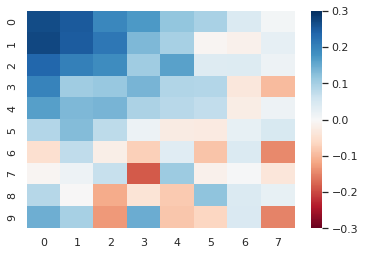

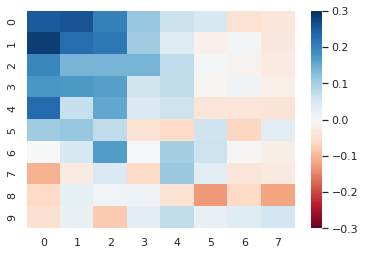

array([0.16666667, 0.66666667, 0.16666667])

In [28]:
import numpy as np; np.random.seed(0)

import seaborn as sns; sns.set_theme()

for i in np.arange(K3):
    ax = sns.heatmap(Delta[i][:][:]-0.1,cmap=plt.cm.RdBu,vmin=-0.3, vmax=0.3)
    plt.show()



ValueError: `bins` must increase monotonically, when an array

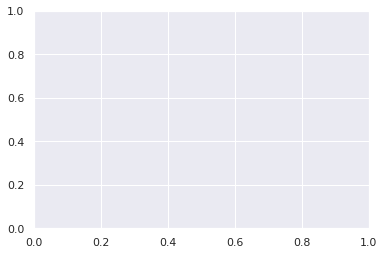

In [29]:
beg=100
end=-1
plt.hist(cmss[beg:end],srs[beg:end])
plt.plot(cmss[beg:end],invs[beg:end],'b.')
plt.show()
plt.plot(cmss[beg:end],fitness[beg:end],'b.')
#plt.plot(cmss[beg:end],r_fitness[beg:end],'g.')

In [136]:
np.shape(r_fitness)


(720000,)

In [73]:
import numpy as np; np.random.seed(0)

import seaborn as sns; sns.set_theme()


ax = sns.heatmap(Delta12,cmap=plt.cm.RdBu,vmin=-0.3, vmax=0.3)
plt.show()

ax = sns.heatmap(Delta22-0.12,cmap=plt.cm.RdBu,vmin=-0.3, vmax=0.3)
plt.show()
ax = sns.heatmap(Delta32-0.185,cmap=plt.cm.RdBu,vmin=-0.3, vmax=0.3)
plt.show()

NameError: name 'Delta12' is not defined

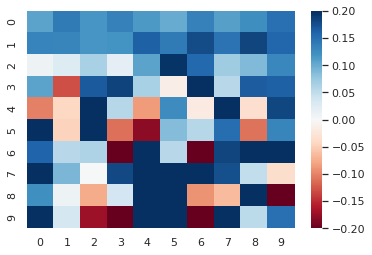

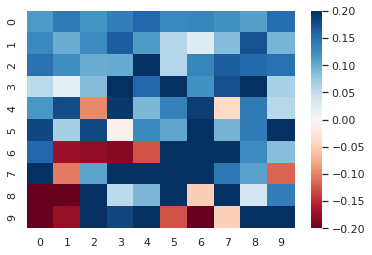

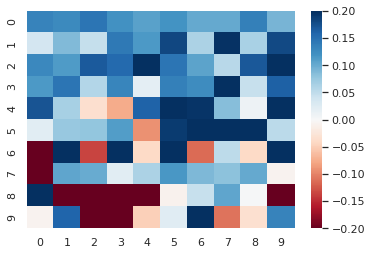

In [59]:
import numpy as np; np.random.seed(0)

import seaborn as sns; sns.set_theme()


ax = sns.heatmap(Delta212,cmap=plt.cm.RdBu,vmin=-0.2, vmax=0.2)
plt.show()

ax = sns.heatmap(Delta222,cmap=plt.cm.RdBu,vmin=-0.2, vmax=0.2)
plt.show()
ax = sns.heatmap(Delta232,cmap=plt.cm.RdBu,vmin=-0.2, vmax=0.2)
plt.show()


In [48]:

states_chain.generate_states(current_state=0,no=10)

[0, 0, 1, 1, 1, 1, 1, 1, 1, 1]

In [68]:
gens=700
POP=700
x_0_inv=0.5
x_0_sr=0.5
ps=np.array([0,0.1,0.2,0.2,0.5,0.5,0.8])
phis=np.array([0,0.1,0.2,0.2,0.3,0.3,0.4])
kappas=np.array([0,0,0.1,0.2,0.2,0.4,0.4])

ff=0.5
fm=0.5

alpha=0.5

Ms=int((1-alpha)*POP)
Fs=POP-Ms
mu=0.5
sigma=0.15
KK=len(ps)


cms=np.linspace(0,1,Ms)
cfs=np.linspace(0,1,Ms)

results=np.zeros((KK,5,gens))

srs = np.empty(KK, dtype=np.object)
for i in range(srs.shape[0]):
    srs[i] = []
    srs[i].append(i)
    
invs = np.empty(KK, dtype=np.object)
for i in range(invs.shape[0]):
    invs[i] = []
    invs[i].append(i)
cmss = np.empty(KK, dtype=np.object)
for i in range(srs.shape[0]):
    cmss[i] = []
    cmss[i].append(i)

def adult_condition(cm,i,cf,phi,kappa,fm,ff):
    
    noise = np.random.normal(phi,kappa,1)
    cm = offs_condition(cm,i)
    
    return  min(np.abs(noise + ff*cf + fm*cm),1 )

KK=len(ps)
    

for kk in np.arange(KK):
    
    Ms=int(POP*(1-alpha))
    Fs=POP-Ms



   
    gen=0


    cms=np.linspace(0,1,Ms)
    cfs=np.linspace(0,1,Fs)

    
    
    results[kk,0,gen]=np.mean(cms)
    results[kk][1][gen]=np.var(cms)
    results[kk][2][gen]=Fs/POP
    results[kk][3][gen]=POP
    results[kk,4,gen]=np.mean(cfs)
    
    

    
    
    p=ps[kk]
    phi=phis[kk]
    kappa=kappas[kk]
    
    
    P=[(0.4,0.3,0.3),(p/2,1-p,p/2),(0.3,0.3,0.4)]

    transition_matrix=np.asarray(P)
    states_chain=MarkovChain(transition_matrix=transition_matrix, states=[0,1,2])

    states=states_chain.generate_states(current_state=0,no=gens)


    

    while gen<(gens-1) and Ms>0 and Fs>0:



        ct=states[gen]

        if ct==0:
            phi=phi
        elif ct==1:
            phi=0
        elif ct==2:
            phi=-phi


        sons=np.zeros((3,5*POP))
        daughters=np.zeros((3,5*POP))


        for i in np.arange(len(cms)):
            cm=max(cms[i],0)
            if i>len(cfs)-1:
                cf=max(cms[i],0)
            else:
                cf=max(cfs[i],0)
            x_pop=results[kk][2][gen]
            sol=optimal_Unc(cm,P,ct,phi,x_0_inv,x_0_sr)

            x=np.int(np.round(2*sol[-2]))

            im=sol[0]
            ix=sol[2]
            iF=sol[1]
            srs[kk].append(sol[-2])
            invs[kk].append(ix/(investment(cm)+0.0000001))
            cmss[kk].append(cm)

            if x==2:
                sons[0,i]=1
                sons[1,i]=adult_condition(cm,im,cf,phi,kappa,fm,ff)
                sons[2,i]=male_fitness(sons[1][i])

                sons[0,Ms+i]=1
                sons[1,Ms+i]=adult_condition(cm,investment(cm)-im,cf,phi,kappa,fm,ff)
                sons[2,Ms+i]=male_fitness(sons[1][Ms+i])

            elif x==1:

                sons[0,i]=1
                sons[1,i]=adult_condition(cm,ix,cf,phi,kappa,fm,ff)
                sons[2,i]=male_fitness(sons[1][i])

                daughters[0,i]=1
                daughters[1,i]=adult_condition(cm,investment(cm)-ix,cf,phi,kappa,fm,ff)
                daughters[2,i]=female_fitness(daughters[1][i])

            elif x==0:

                daughters[0,i]=1
                daughters[1,i]=adult_condition(cm,iF,cf,phi,kappa,fm,ff)
                daughters[2,i]=female_fitness(daughters[1][i])

                daughters[0,Ms+i]=1
                daughters[1,Ms+i]=adult_condition(cm,investment(cm)-iF,cf,phi,kappa,fm,ff)
                daughters[2,Ms+i]=female_fitness(daughters[1][Ms+i])

            # remove zeros#


        idx1 = np.argwhere(np.all(daughters[:, :] == 0,axis=0))
        daughters = np.delete(daughters, idx1,axis=1)

        idx = np.argwhere(np.all(sons[:, :] == 0,axis=0))
        sons = np.delete(sons, idx,axis=1)

        pop=np.sum(daughters[0][:])+np.sum(sons[0][:])

        daughters[0][:]=daughters[0][:]+2
        newpop=np.concatenate((sons,daughters),axis=1)

        if pop>POP:    
            idx = (-newpop[2,:]).argsort()[:POP]
            newpop=newpop[:,idx]



        cfs=[]
        cms=[]


        for i in np.arange(len(newpop[0])):
            if newpop[0][i]==1:
                cfs.append(newpop[1][i])
            else :
                cms.append(newpop[1][i])

        cms=np.asarray(cms)
        cfs=np.asarray(cfs)
        
        Ms=len(cms)
        Fs=len(cfs)

       # Ms=Ms+10
        #Fs=Fs+10

        gen=gen+1
        
        if pop>0 and Ms>0 and Fs>0:

            results[kk][0][gen]=np.mean(cms)
            results[kk][1][gen]=np.var(cms)
            results[kk][2][gen]=Fs/pop
            results[kk][3][gen]=pop
            results[kk][4][gen]=np.mean(cfs)





















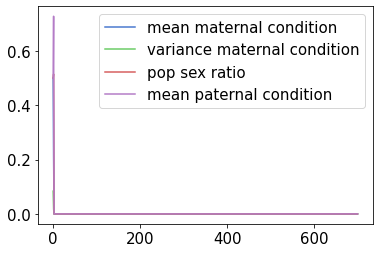

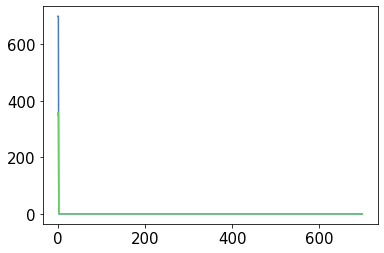

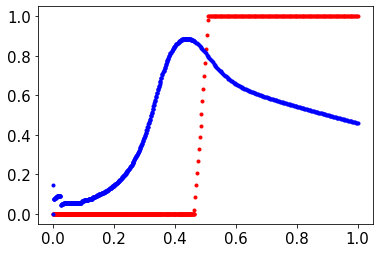

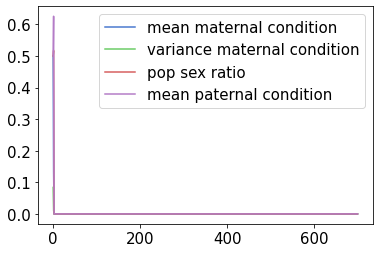

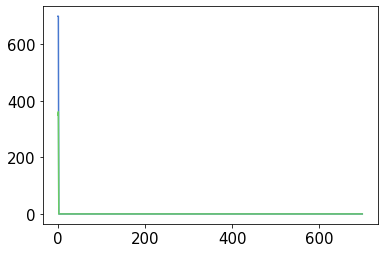

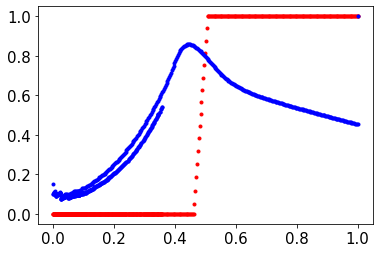

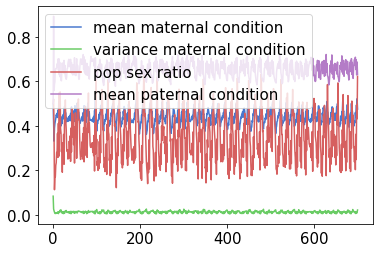

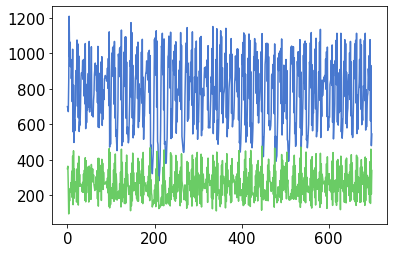

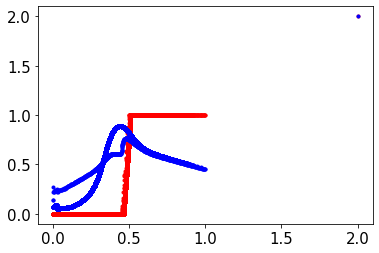

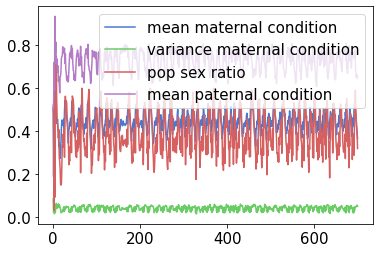

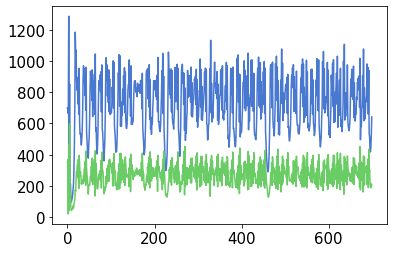

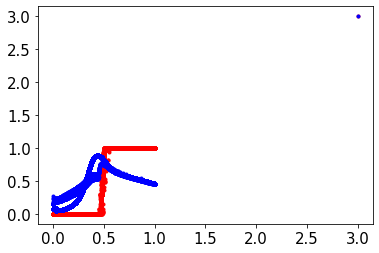

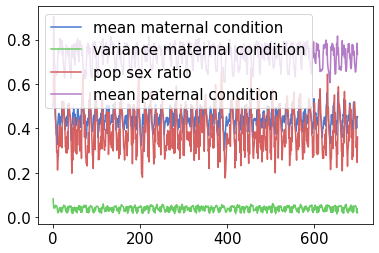

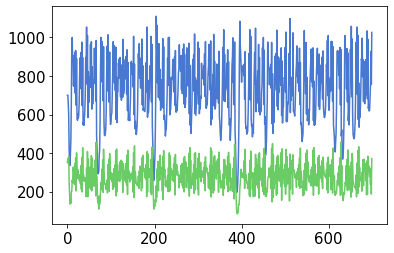

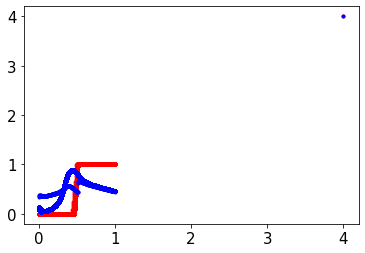

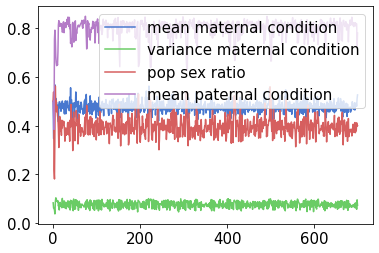

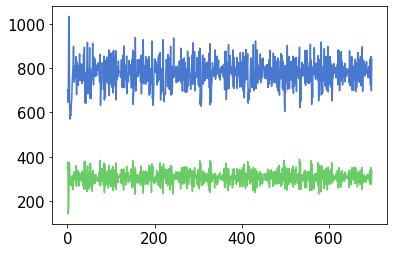

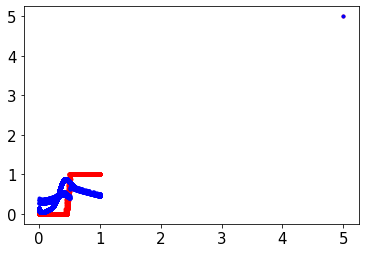

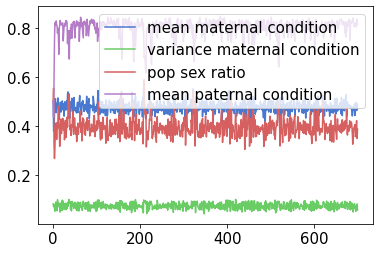

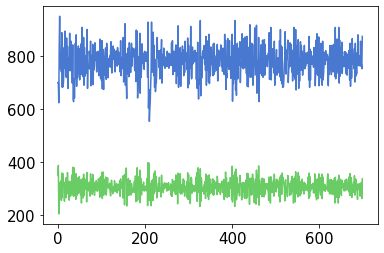

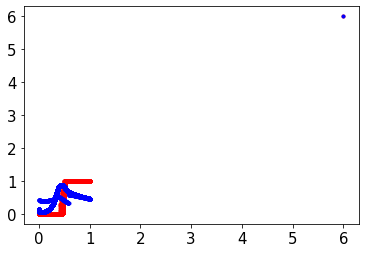

In [69]:
idx = np.argwhere(np.all(results[0,:, :] == 0,axis=1))
results = np.delete(results, idx,axis=2)

beg=0
end=20
for kk in np.arange(KK):
    gen=len(results[kk][0][:])
    plt.plot(np.arange(gen),results[kk][0][:],label='mean maternal condition')
    plt.plot(np.arange(gen),results[kk][1][:],label='variance maternal condition')
    plt.plot(np.arange(gen),results[kk][2][:],label='pop sex ratio')
    plt.plot(np.arange(gen),results[kk][4][:],label='mean paternal condition')
    plt.legend()
    plt.show()
    plt.plot(np.arange(gen),results[kk][3][:])
    plt.plot(np.arange(gen),results[kk][3][:]*results[kk][2][:])
    plt.show()
    plt.plot(cmss[kk],srs[kk],'r.',cmss[kk],invs[kk],'b.')
    plt.show()


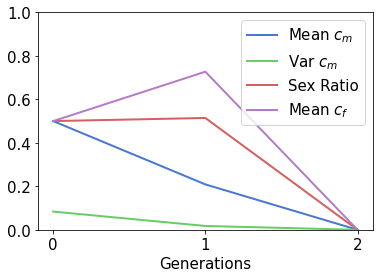

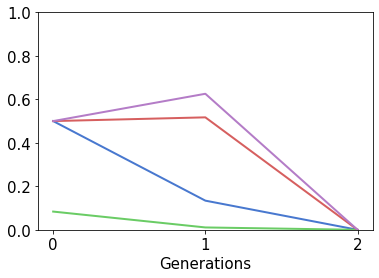

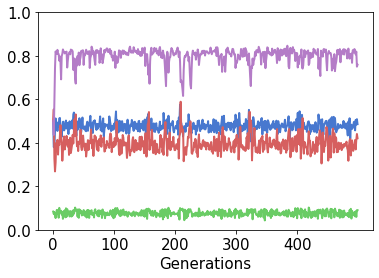

In [85]:
plt.rcParams.update({'font.size': 15})
plt.style.use("seaborn-muted")  #
gen=3
kk=0

plt.plot(np.arange(gen),results[kk][0][0:gen],label='Mean $c_m$',linewidth=2.0)
plt.plot(np.arange(gen),results[kk][1][0:gen],label='Var $c_m$',linewidth=2.0)
plt.plot(np.arange(gen),results[kk][2][0:gen],label='Sex Ratio',linewidth=2.0)
plt.plot(np.arange(gen),results[kk][4][0:gen],label='Mean $c_f$',linewidth=2.0)
plt.legend()
x_ticks = np.arange(gen)
plt.xticks(x_ticks)
plt.ylim([0,1])
plt.xlabel('Generations')

plt.savefig("gens52.png",dpi=300)
plt.show()



gen=3
kk=1

plt.plot(np.arange(gen),results[kk][0][0:gen],label='Mean $c_m$',linewidth=2.0)
plt.plot(np.arange(gen),results[kk][1][0:gen],label='Var $c_m$',linewidth=2.0)
plt.plot(np.arange(gen),results[kk][2][0:gen],label='Sex Ratio',linewidth=2.0)
plt.plot(np.arange(gen),results[kk][4][0:gen],label='Mean $c_f$',linewidth=2.0)
plt.ylim([0,1])
#plt.legend()
x_ticks = np.arange(0,gen)
plt.xticks(x_ticks)
plt.xlabel('Generations')

plt.savefig("gens510.png",dpi=300)
plt.show()

gen=500
kk=-1

plt.plot(np.arange(gen),results[kk][0][0:gen],label='Mean $c_m$',linewidth=2.0)
plt.plot(np.arange(gen),results[kk][1][0:gen],label='Var $c_m$',linewidth=2.0)
plt.plot(np.arange(gen),results[kk][2][0:gen],label='Sex Ratio',linewidth=2.0)
plt.plot(np.arange(gen),results[kk][4][0:gen],label='Mean $c_f$',linewidth=2.0)
#plt.legend(
plt.ylim([0,1])
x_ticks = np.arange(0,gen,100)
plt.xticks(x_ticks)
plt.xlabel('Generations')

plt.savefig("gens500.png",dpi=300)
plt.show()

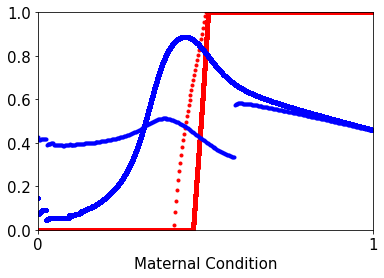

In [90]:
plt.rcParams.update({'font.size': 15})
plt.style.use("seaborn-muted")  #
gen=3
kk=-1

plt.plot(cmss[kk],srs[kk],'r.',label='Sex Ratio')

plt.plot(cmss[kk],invs[kk],'b.',label='Investment Ratio')
#plt.legend()
x_ticks = np.arange(gen)
plt.xticks(x_ticks)
plt.ylim([0,1])
plt.xlabel('Maternal Condition')
plt.xlim([0,1])
plt.savefig("invgens52un.png",dpi=300)
plt.show()